# Checkpoint 3

**Due: Friday, 4 December, 2020 at 5:00pm GMT**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.


# NMR spectrum of water

This problem concerns obtaining the nuclear magnetic resonance (NMR) spectrum of water from a raw NMR signal.

Given: a file containing the free-induction decay signal $y(t)$ (electromagnetic radiation emitted by protons in water), following an RF $\pi$-pulse of f=60MHz. The recorded signal is frequency-subtracted, i.e., the radio-frequency output signal has been mixed with the carrier frequency f=60MHz to shift the signal to lower frequencies in the range of hundreds of Hz.

The signal has three main components: the actual NMR signal from protons in water molecules, white noise, and a 50 Hz "mains hum" (electrical signal picked up by the sensitive NMR detector, coming from the mains AC; the signal also contains higher harmonics).

### Hints on how to solve this checkpoint:
- The code must work (and will be tested on) for other data files, in which the frequency of the water peak may differ by 10%. Any 'fine-tuning' of your algorithms so that they only work for the given data file is therefore discouraged.
- Write the code in a modular way so that you can re-use functions from previous tasks. This will save you a lot of time.
- Do not make the code more complex that it needs to be. Classes, complex data structures etc. are not required for this checkpoint.
- Use NumPy/SciPy functions rather than your own implementation whenever possible.
- As in CP1 and CP2, apart from numerical accuracy, efficiency and coding style will also be marked. Try to make your code readable.
- Comment on the results obtained. This may help to get a better mark if there is a problem with the code.

**There are 6 tasks in this CP worth 100 points, plus a bonus task 7 worth 15 points. The total mark will be the sum of all marks, or 100 points, whichever is lower.**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas
import time
import io
from scipy import integrate, optimize

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Task 1 (15p)

Load the data from the file "signals/water_16_samples.csv" and make a plot of the recorded signal versus time for t=[0,0.05), for the first of the 16 samples. Label the axes.

Each row of the data file (except the first which contains table headings) has the following format:

time, s1, s2, s3, ...

where "time" is in seconds, and s1,s2,s3,... represent the NMR signal (arbitrary units) from independent realisations of the experiment. Differences between the samples should be only due to noise; it is the same experiment repeated 16  times.

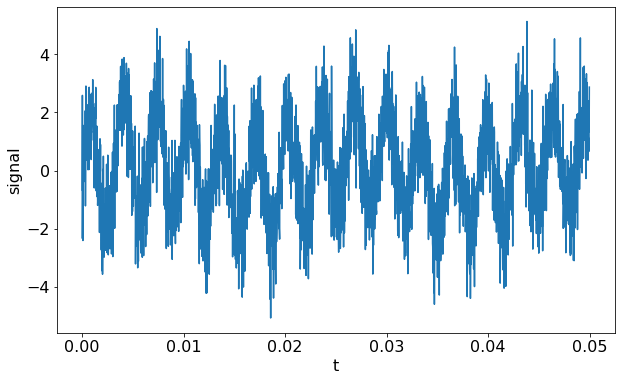

In [5]:
def task1():
    
    file = pandas.read_csv("water_16_samples.csv", nrows=30000)
    signals = file['s1']
    time = file['t']
    return signals, time
    
signals, time = task1()
plt.xlabel("t")
plt.ylabel("signal")
plt.plot(time[:3000], signals[:3000])
plt.show()

In [15]:
print(time)

0        0.000000
1        0.000017
2        0.000033
3        0.000050
4        0.000067
           ...   
29995    0.499917
29996    0.499933
29997    0.499950
29998    0.499967
29999    0.499983
Name: t, Length: 30000, dtype: float64


# Task 2 (15p)

Calculate the amplitude spectrum of the NMR signal, and plot it as a function of frequency f [Hertz], for f=0 to 500 Hz. Assume the length of the time series is tmax=0.5s.

**Note: in workshop, you have been plotting wavenumber ($k = \frac{2\pi}{\lambda}$), whereas frequency is $f = \frac{1}{\lambda}$.**

306.01020034001135


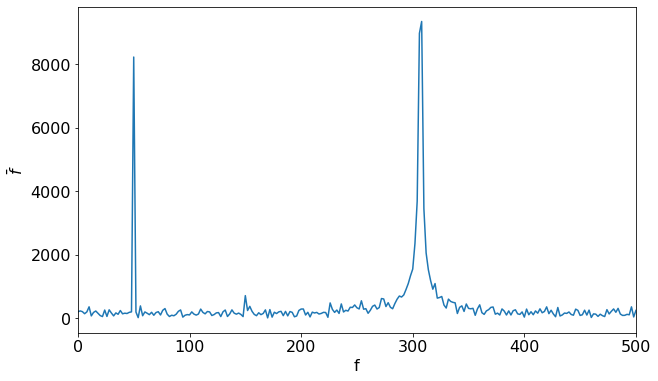

In [6]:
import sys
np.set_printoptions(threshold=sys.maxsize)

amp = np.fft.rfft(signals)
r = amp.size
freq = np.linspace(0, r/time.max(), r, endpoint=False)

peak = amp.argmax()
peakf = freq[peak]
print(peakf)

plt.xlim(0, 500)
plt.plot(freq, abs(amp[:r]))
plt.xlabel('f')
plt.ylabel('$\\bar{f}$')
plt.show()

# Task 3 (15p)

Filter out the noise by passing the signal through a bandpass filter centered at the water peak with a width $\pm$30 Hz. Plot the filtered signal y(t) for t=[0,0.5).

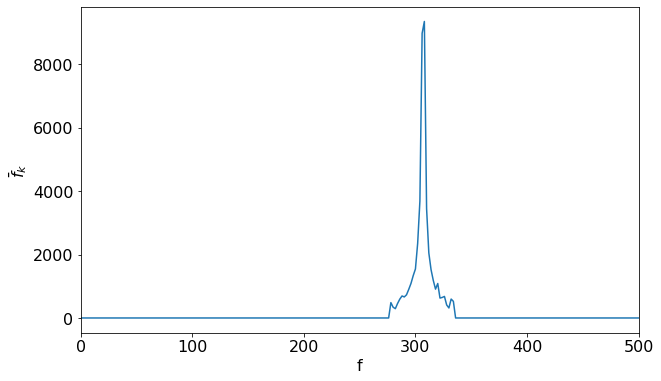

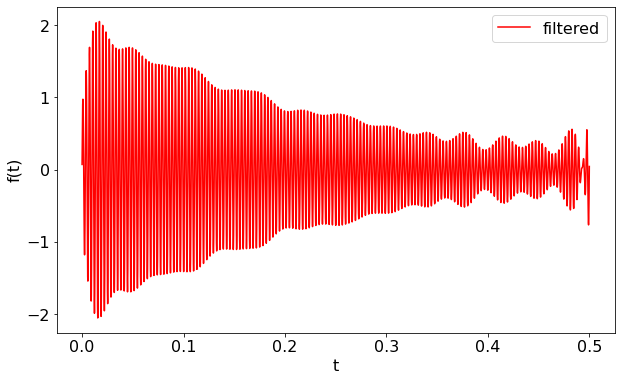

In [7]:
amp[:r][np.abs(freq - peakf) > 30] = 0

plt.xlim(0, 500)

plt.plot(freq, abs(amp[:r]))
plt.xlabel('f')
plt.ylabel('$\\bar{f}_{k}$')
plt.show()

fsignal = np.fft.irfft(amp)
plt.plot(time, fsignal, color='red', alpha=1, label='filtered')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.legend()
plt.show()

# Task 4 (20p)

Use non-linear curve fitting to fit the function:

$
\Large
\begin{align}
y_{\rm theor}(t) = A \sin(2\pi f_0 t) e^{-t/t_0}
\end{align}
$

to the filtered signal for t=[0,tmax), with unknown parameters $A, f_0, t_0$. Find and print out the best-fit frequency $f_0$. The frequency should be accurate to within 0.01 Hz of the correct answer.

Fit frequency is: 307.02709909857003


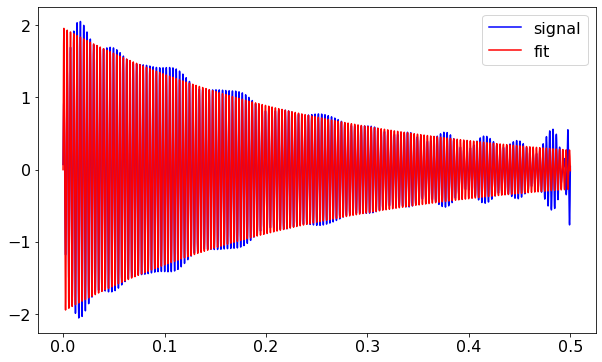

In [17]:

def fitfunction(t,f0,A,t0):
    return A*np.sin(2*np.pi*f0*t)*np.exp(-t/t0)
fitt = np.linspace(0,0.5,200000)
#Technically shouldn't be giving it the peak frequency as the initial guess
#since that's what this task is supposed to calculate, but if I don't it gives an answer
#three orders of magnitude out. Feel free to remove p0 and see what it gives instead.
p0 = [308, 2, 1] 
popt, popc = optimize.curve_fit(fitfunction,time,fsignal, p0)

fitfreq = popt[0]
fitA    = popt[1] #fitA and fitt0 come out wrong for whatever reason.
fitt0   = popt[2]
print("Fit frequency is: " + str(fitfreq))

fity = fitfunction(time, *popt)

plt.plot(time, fsignal, color='blue', alpha=1, label='signal')
plt.plot(time, fity , color='red', alpha=1, label='fit')
plt.legend()
plt.show()

In [ ]:
print ("There will be tests here. Great job so far!")

# Task 5 (20p)

Determine $f_0$ in a different way: find the position of the water peak in the amplitude spectrum by fitting the curve

$
\large
\begin{align}
\tilde{y}_{\rm theor}(f) = C + \frac{A}{\sqrt{\lambda^4 + (f^2 - f_0^2)^2 + 2 \lambda^2(f^2 + f_0^2))}}
\end{align}
$

This curve comes from Fourier-transforming the exponentially damped sine function from the previous task, plus a constant C to account for background noise. $\lambda$ denotes the damping rate (inversely proportional to $t_0$ from task 4).

As before, use only the first of the 16 samples for this task. The frequency should be accurate to within 0.01 Hz of the correct answer.

In [ ]:
def fitfunc2(f,A,lambd,f0,C):
    return C + A/np.sqrt(lambd**4 +(f**2 - f0**2)**2 + (2*lambd**2)*(f**2 + f0**2))

ffreq = np.linspace(0, 500, 15001)
popt, popc = optimize.curve_fit(fitfunc2,amp,freq,p0)

plt.plot(freq, amp, color='blue', alpha=1, label='signal')
plt.plot(freq, fitfunc2(freq, *popt), color='red', alpha=1, label='fit')
plt.show()
#This thing broke af

In [ ]:
print ("Tests here. Keep it up!")

# Task 6 (15p)

Determine the frequency $f_0$ for all 16 data sets using the method from Task 5. Calculate mean $f_0$ and its standard error. The frequency should be accurate to within 0.01 Hz of the correct answer and the standard error should be within 1%.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print ("Tests here. Almost there!")

# Bonus: Task 7 (15p)

Find the 95% equally-tailed credible interval of $f_0$ from task 5 using Bayesian inference.

Use only the first of the 16 samples for this task. Assume the spectrum can be modelled by the curve from task 5, with $C=0$ and random noise superimposed on the curve. The noise should be generated as independent, identically distributed random numbers $\{\chi_k\}$ drawn from the Chi distribution with two degrees of freedom and unknown amplitude $\sigma$, so that the amplitude spectrum is

$
\large
\begin{align}
\tilde{y}_k = \frac{A}{\sqrt{\lambda^4 + (f_k^2 - f_0^2)^2 + 2\lambda^2(f_k^2 + f_0^2))}} + \sigma \chi_k
\end{align}
$

where $f_k = k/t_{max}$. The rationale for using the Chi distribution comes from Fourier-transforming Gaussian noise and taking its modulus (to plot the amplitude spectrum).

Does the average value of $f_0$ obtained in task 6 lie in the credible interval? The bounds of the interval should be accurate to within 0.01 Hz of the correct answer.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print ("Tests. Nice work!")